In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pylab as plt
%matplotlib inline

## 変分ベイズって？

・ベイズの式を直接計算せず、求めたい分布の近似モデルを用意し、KL情報量を基準に近似モデルを求めたい分布に近づけていく

### 詳解確率ロボティクスのサンプルコードを読んでいく
https://github.com/ryuichiueda/LNPR/blob/master/inference/variational_inference.ipynb

・特定の環境条件に対応した何種類かのガウス分布がある

・ガウス分布はK個存在する（以後 $ k = 0,1, 2, ..., K-1$ ）

・各ガウス分布の平均値、精度はそれぞれ $ μ_k, λ_k $ 

・各センサ値 $ z_i $ は、ガウス分布のどれかから生成されたものと考える

・一つのセンサ値が生成される時、$ k $ 番目のガウス分布から生成される確率は $ π_k $である

In [2]:
import pandas as pd 
import math, random
all_data  = pd.read_csv("sensor_data_600.txt", delimiter=" ", header=None, names = ("date","time","ir","z"))#lidarのセンサ値は「z」に
data = all_data.sample(3000).sort_values(by="z").reset_index()  #1000個だけサンプリングしてインデックスを振り直す
data = pd.DataFrame(data["z"])

In [3]:
##負担率の初期化## 

K = 3 #クラスタ数
n = int(math.ceil(len(data)/K)) #クラスタあたりのセンサ値の数
for k in range(K):
    data[k] = [1.0 if k == int(i/n) else 0.0 for i,d in data.iterrows()] #データをK個に分けて、一つのr_{i,k}を1に。他を0に。

In [4]:
def update_parameters(ds, k, mu_avg=600, zeta=1, alpha=1, beta=1, tau=1): 
    R = sum([d[k] for _, d in ds.iterrows()])
    S = sum([d[k]*d["z"] for _, d in ds.iterrows()])
    T = sum([d[k]*(d["z"]**2) for _, d in ds.iterrows()])
    
    hat = {}

    hat["tau"] = R + tau
    hat["zeta"] = R + zeta
    hat["mu_avg"] = (S + zeta*mu_avg)/hat["zeta"]
    hat["alpha"] = R/2 + alpha
    hat["beta"] = (T + zeta*(mu_avg**2) - hat["zeta"]*(hat["mu_avg"]**2))/2 + beta
    
    hat["z_std"] = math.sqrt(hat["beta"]/hat["alpha"])
    
    return pd.DataFrame(hat, index=[k])

In [5]:
from scipy.stats import norm, dirichlet
import matplotlib.pyplot as plt
import numpy as np

def draw(ps):
    pi = dirichlet([ps["tau"][k] for k in range(K)]).rvs()[0]
    pdfs = [ norm(loc=ps["mu_avg"][k], scale=ps["z_std"][k]) for k in range(K) ]

    xs = np.arange(600,650,0.5)

    ##p(z)の描画##
    ys = [ sum([pdfs[k].pdf(x)*pi[k] for k in range(K)])*len(data) for x in xs] #pdfを足してデータ数をかける
    plt.plot(xs, ys, color="red")

    ##各ガウス分布の描画##
    for k in range(K):
        ys = [pdfs[k].pdf(x)*pi[k]*len(data) for x in xs]
        plt.plot(xs, ys, color="blue")

    ##元のデータのヒストグラムの描画##
    data["z"].hist(bins = max(data["z"]) - min(data["z"]), align='left', alpha=0.4, color="gray")
    plt.show()

In [6]:
from scipy.special import digamma 

def responsibility(z, K, ps):
    tau_sum = sum([ps["tau"][k] for k in range(K)])
    r = {}
    for k in range(K):
        log_rho = (digamma(ps["alpha"][k]) - math.log(ps["beta"][k]))/2 \
                            - (1/ps["zeta"][k] + ((ps["mu_avg"][k] - z)**2)*ps["alpha"][k]/ps["beta"][k])/2 \
                            + digamma(ps["tau"][k]) - digamma(tau_sum)
                
        r[k] = math.exp(log_rho)
       
    w = sum([ r[k] for k in range(K) ]) #正規化
    for k in range(K): r[k] /= w
    
    return r

In [7]:
def one_step(ds):
    ##パラメータの更新##
    params = pd.concat([update_parameters(ds, k) for k in range(K)]) 

    ##負担率の更新##
    rs = [responsibility(d["z"], K, params) for _, d in ds.iterrows() ]
    for k in range(K):
        ds[k] = [rs[i][k] for i,_ in data.iterrows()]
        
    return ds, params

In [8]:
params_history = {} 
for t in range(1, 10000):
    data, params = one_step(data)
    if t%10 ==0:              #10回ごとにパラメータを記録
        params_history[t] = params
        display(params)
        
        if len(params_history) < 2:
            continue
           
        if all([ abs(params_history[t-10]["tau"][k] - params_history[t]["tau"][k]) < 10e-5 for k in range(K)]):
            break

,tau,zeta,mu_avg,alpha,beta,z_std
0,1002.124596,1002.124596,620.492470,501.562298,5180.768781,3.213917
1,923.179882,923.179882,627.996300,462.089941,7375.648854,3.995185
2,1077.695522,1077.695522,632.118878,539.347761,7422.562710,3.709732


,tau,zeta,mu_avg,alpha,beta,z_std
0,962.493598,962.493598,620.536838,481.746799,5109.386552,3.256679
1,893.197698,893.197698,628.209799,447.098849,10264.193340,4.791380
2,1147.308704,1147.308704,631.406104,574.154352,8508.625062,3.849598


,tau,zeta,mu_avg,alpha,beta,z_std
0,935.809607,935.809607,620.540470,468.404804,4907.453724,3.236812
1,841.821214,841.821214,628.096294,421.410607,11338.036724,5.186999
2,1225.369178,1225.369178,631.110603,613.184589,9147.992329,3.862489


,tau,zeta,mu_avg,alpha,beta,z_std
0,919.231157,919.231157,620.551840,460.115578,4755.465075,3.214867
1,780.169376,780.169376,627.783905,390.584688,11387.608965,5.399564
2,1303.599467,1303.599467,631.012559,652.299733,9788.078694,3.873692


,tau,zeta,mu_avg,alpha,beta,z_std
0,908.267851,908.267851,620.576378,454.633926,4643.669576,3.195948
1,717.220201,717.220201,627.392328,359.110101,11065.421264,5.550986
2,1377.511947,1377.511947,630.969464,689.255974,10419.834243,3.888124


,tau,zeta,mu_avg,alpha,beta,z_std
0,902.418821,902.418821,620.605387,451.709410,4564.094625,3.178687
1,655.747791,655.747791,626.996761,328.373895,10536.449054,5.664516
2,1444.833389,1444.833389,630.936609,722.916694,11029.302957,3.905979


,tau,zeta,mu_avg,alpha,beta,z_std
0,901.978574,901.978574,620.631660,451.489287,4522.469939,3.164930
1,596.600398,596.600398,626.642357,298.800199,9860.215645,5.744507
2,1504.421028,1504.421028,630.903479,752.710514,11602.904343,3.926172


,tau,zeta,mu_avg,alpha,beta,z_std
0,906.346935,906.346935,620.653571,453.673468,4518.908742,3.156059
1,540.222651,540.222651,626.343098,270.611326,9110.404714,5.802242
2,1556.430414,1556.430414,630.869071,778.715207,12127.431822,3.946345


,tau,zeta,mu_avg,alpha,beta,z_std
0,914.305788,914.305788,620.672280,457.652894,4545.895970,3.151677
1,486.863828,486.863828,626.092420,243.931914,8349.529517,5.850550
2,1601.830385,1601.830385,630.834575,801.415192,12598.507728,3.964887


,tau,zeta,mu_avg,alpha,beta,z_std
0,924.659470,924.659470,620.688925,462.829735,4594.365621,3.150664
1,436.577443,436.577443,625.877501,218.788721,7611.192939,5.898124
2,1641.763087,1641.763087,630.801190,821.381543,13019.498633,3.981298


,tau,zeta,mu_avg,alpha,beta,z_std
0,936.492374,936.492374,620.704010,468.746187,4657.018082,3.151992
1,389.284521,389.284521,625.686304,195.142260,6907.790351,5.949684
2,1677.223106,1677.223106,630.769652,839.111553,13396.833646,3.995685


,tau,zeta,mu_avg,alpha,beta,z_std
0,949.170838,949.170838,620.717663,475.085419,4728.779718,3.154922
1,344.844109,344.844109,625.509109,172.922055,6241.366302,6.007789
2,1708.985052,1708.985052,630.740311,854.992526,13736.987475,4.008340


,tau,zeta,mu_avg,alpha,beta,z_std
0,962.276062,962.276062,620.729877,481.638031,4806.354408,3.158985
1,303.097442,303.097442,625.338110,152.048721,5609.908152,6.074164
2,1737.626497,1737.626497,630.713286,869.313248,14045.375936,4.019560


,tau,zeta,mu_avg,alpha,beta,z_std
0,975.538798,975.538798,620.740622,488.269399,4887.713908,3.163903
1,263.890680,263.890680,625.166639,132.445340,5010.145739,6.150449
2,1763.570521,1763.570521,630.688581,882.285261,14326.189924,4.029590


,tau,zeta,mu_avg,alpha,beta,z_std
0,988.790376,988.790376,620.749881,494.895188,4971.716206,3.169542
1,227.086110,227.086110,624.988379,114.043055,4438.653405,6.238658
2,1787.123514,1787.123514,630.666153,894.061757,14582.539436,4.038618


,tau,zeta,mu_avg,alpha,beta,z_std
0,1001.928812,1001.928812,620.757645,501.464406,5057.857252,3.175874
1,192.567989,192.567989,624.796511,96.783994,3892.230612,6.341581
2,1808.503200,1808.503200,630.645953,904.751600,14816.648336,4.046787


,tau,zeta,mu_avg,alpha,beta,z_std
0,1014.896173,1014.896173,620.763912,507.948086,5146.130682,3.182957
1,160.246491,160.246491,624.582606,80.623245,3367.987355,6.463312
2,1827.857337,1827.857337,630.627942,914.428668,15030.012509,4.054196


,tau,zeta,mu_avg,alpha,beta,z_std
0,1027.663764,1027.663764,620.768676,514.331882,5236.977867,3.190940
1,130.061976,130.061976,624.334809,65.530988,2863.307120,6.610139
2,1845.274260,1845.274260,630.612117,923.137130,15223.497163,4.060917


,tau,zeta,mu_avg,alpha,beta,z_std
0,1040.222642,1040.222642,620.771922,520.611321,5331.331911,3.200082
1,101.991846,101.991846,624.034288,51.495923,2375.750611,6.792255
2,1860.785513,1860.785513,630.598516,930.892756,15397.361395,4.066992


,tau,zeta,mu_avg,alpha,beta,z_std
0,1052.577474,1052.577474,620.773615,526.788737,5430.791765,3.210801
1,76.063915,76.063915,623.647055,38.531957,1902.906495,7.027457
2,1874.358611,1874.358611,630.587249,937.679305,15551.184875,4.072439


,tau,zeta,mu_avg,alpha,beta,z_std
0,1064.741112,1064.741112,620.773691,532.870556,5538.034979,3.223792
1,52.386257,52.386257,623.101047,26.693128,1442.141371,7.350285
2,1885.872631,1885.872631,630.578534,943.436316,15683.621593,4.077246


,tau,zeta,mu_avg,alpha,beta,z_std
0,1076.719837,1076.719837,620.772060,538.859919,5657.738950,3.240287
1,31.227516,31.227516,622.201250,16.113758,990.057881,7.838480
2,1895.052646,1895.052646,630.572777,948.026323,15791.731289,4.081358


,tau,zeta,mu_avg,alpha,beta,z_std
0,1088.418762,1088.418762,620.768708,544.709381,5798.354795,3.262646
1,13.315570,13.315570,620.111110,7.157785,540.387994,8.688875
2,1901.265668,1901.265668,630.570771,951.132834,15868.743759,4.084611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1098.659033,1098.659033,620.766120,549.829516,5961.421553,3.292766
1,1.754690,1.754690,606.604674,1.377345,60.991443,6.654464
2,1902.586277,1902.586277,630.573923,951.793139,15889.706743,4.085890


,tau,zeta,mu_avg,alpha,beta,z_std
0,1102.919542,1102.919542,620.777078,551.959771,6033.161261,3.306121
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1899.080458,1899.080458,630.583514,950.040229,15828.104892,4.081722


,tau,zeta,mu_avg,alpha,beta,z_std
0,1105.103666,1105.103666,620.784466,553.051833,6057.175770,3.309422
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1896.896334,1896.896334,630.590502,948.948167,15779.056316,4.077738


,tau,zeta,mu_avg,alpha,beta,z_std
0,1106.346235,1106.346235,620.788659,553.673118,6070.823405,3.311289
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1895.653765,1895.653765,630.594482,948.326882,15751.130035,4.075462


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.052881,1107.052881,620.791046,554.02644,6078.602825,3.312353
1,1.000000,1.000000,600.000000,1.00000,1.000000,1.000000
2,1894.947119,1894.947119,630.596745,947.97356,15735.276345,4.074169


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.454743,1107.454743,620.792404,554.227371,6083.032876,3.312959
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.545257,1894.545257,630.598031,947.772629,15726.269774,4.073435


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.683277,1107.683277,620.793176,554.341639,6085.554143,3.313304
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.316723,1894.316723,630.598762,947.658361,15721.150783,4.073017


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.813241,1107.813241,620.793615,554.406621,6086.988574,3.31350
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.00000
2,1894.186759,1894.186759,630.599178,947.593379,15718.240663,4.07278


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.88715,1107.88715,620.793865,554.443575,6087.804493,3.313612
1,1.00000,1.00000,600.000000,1.000000,1.000000,1.000000
2,1894.11285,1894.11285,630.599414,947.556425,15716.586059,4.072645


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.929182,1107.929182,620.794007,554.464591,6088.268617,3.313676
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.070818,1894.070818,630.599549,947.535409,15715.645173,4.072568


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.953083,1107.953083,620.794088,554.476542,6088.532568,3.313712
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.046917,1894.046917,630.599625,947.523458,15715.110124,4.072525


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.966676,1107.966676,620.794134,554.483338,6088.682643,3.313732
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.033324,1894.033324,630.599669,947.516662,15714.805888,4.072500


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.974407,1107.974407,620.794160,554.487204,6088.768037,3.313744
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.025593,1894.025593,630.599694,947.512796,15714.632878,4.072486


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.978803,1107.978803,620.794175,554.489401,6088.816588,3.313751
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.021197,1894.021197,630.599708,947.510599,15714.534472,4.072478


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.981303,1107.981303,620.794184,554.490651,6088.844207,3.313754
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.018697,1894.018697,630.599716,947.509349,15714.478498,4.072473


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.982724,1107.982724,620.794188,554.491362,6088.859874,3.313757
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.017276,1894.017276,630.599720,947.508638,15714.446718,4.072471


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.983532,1107.983532,620.794191,554.491766,6088.868779,3.313758
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.016468,1894.016468,630.599723,947.508234,15714.428616,4.072469


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.983993,1107.983993,620.794193,554.491996,6088.873889,3.313758
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.016007,1894.016007,630.599724,947.508004,15714.418322,4.072468


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.984254,1107.984254,620.794194,554.492127,6088.876732,3.313759
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.015746,1894.015746,630.599725,947.507873,15714.412463,4.072468


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.984404,1107.984404,620.794194,554.492202,6088.878423,3.313759
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.015596,1894.015596,630.599725,947.507798,15714.409120,4.072468


,tau,zeta,mu_avg,alpha,beta,z_std
0,1107.984488,1107.984488,620.794194,554.492244,6088.879357,3.313759
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1894.015512,1894.015512,630.599726,947.507756,15714.407246,4.072467


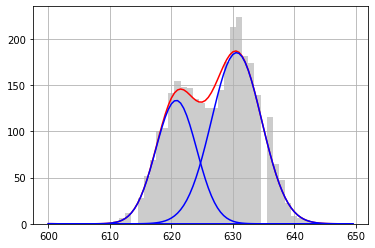

In [9]:
draw(params)

## 難しい…のでライブラリに頼ってみる

(array([ 22.,  80., 273., 590., 391., 445., 792., 254., 135.,  18.]),
 array([610. , 613.3, 616.6, 619.9, 623.2, 626.5, 629.8, 633.1, 636.4,
        639.7, 643. ]),
 <a list of 10 Patch objects>)

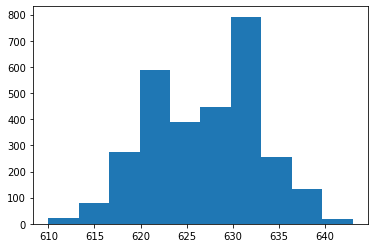

In [10]:
# センサデータの分布
plt.hist(data['z'].values)

In [11]:
# 一旦、二個の混合ガウス分布を仮定
k = 2

In [12]:
if 0:
    # pm.NormalMixtureを知らなかった時のコード（k個対応）
    with pm.Model() as model:
        # k番目のガウス分布の平均を求めるためのハイパーパラメータ
        alpha = pm.Beta("alpha", 1, 1, shape=k)
        beta = pm.Beta("beta", 1, 1, shape=k)
        # k番目のガウス分布の平均と精度
        mu = pm.Gamma("mu", alpha, beta, shape=k)
        sigma = pm.Beta("sigma", 1, 1, shape=k)
        # k番目のガウス分布の重み
        a = np.ones(k)
        pi = pm.Dirichlet("pi", a, shape=k)
        # k番目のガウス分布から選んだセンサ値と重みを積和
        z = pm.Normal("z", mu, sigma, shape=k)
        obs_value = 0
        for i in range(k):
            obs_value += pi[i] * z[i]
        # obs = pm.Deterministic('obs', obs_value, observed=data['z'].values)
        obs = pm.Normal('obs', obs_value, tau = 1000000000, observed=data['z'].values)

        start = pm.find_MAP()#初期値を最大事後確率とする
        trace = pm.sample(start=start) # MCMC

    burnin = 100
    chain = trace[burnin:]#最初のburnin個のデータを抜く→これは最初の方のデータが当てにならないため
    pm.traceplot(trace)

In [13]:
if 0:
    # pm.NormalMixtureを知らなかった時のコード（k=2）
    with pm.Model() as model:
        # k番目のガウス分布の平均を求めるためのハイパーパラメータ
        alpha_0 = pm.Beta("alpha_0", 1, 1)
        beta_0 = pm.Beta("beta_0", 1, 1)
        alpha_1 = pm.Beta("alpha_1", 1, 1)
        beta_1 = pm.Beta("beta_1", 1, 1)
        # k番目のガウス分布の平均と精度
        mu_0 = pm.Gamma("mu_0", alpha_0, beta_0)
        sigma_0 = pm.Beta("sigma_0", 1, 1)
        mu_1 = pm.Gamma("mu_1", alpha_1, beta_1)
        sigma_1 = pm.Beta("sigma_1", 1, 1)
        # k番目のガウス分布の重み
        a = np.ones(2)
        pi = pm.Dirichlet("pi", a, shape=2)
        # k番目のガウス分布から選んだセンサ値と重みを積和
        z_0 = pm.Normal("z_0", mu_0, sigma_0)
        z_1 = pm.Normal("z_1", mu_1, sigma_1)
        obs = pm.Normal('obs', pi[0]*z_0+pi[1]*z_1, 1000000000, observed=data['z'].values)

        start = pm.find_MAP()#初期値を最大事後確率とする
        trace = pm.sample(10000, start=start) # MCMC

    burnin = 100
    chain = trace[burnin:]#最初のburnin個のデータを抜く→これは最初の方のデータが当てにならないため
    pm.traceplot(trace)

In [14]:
if 0:
    # pm.NormalMixtureを知らなかった時のコード(k=2) 
    with pm.Model() as model:
        # k番目のガウス分布の平均を求めるためのハイパーパラメータ
        alpha_0 = pm.Beta("alpha_0", 1, 1)
        beta_0 = pm.Beta("beta_0", 1, 1)
        alpha_1 = pm.Beta("alpha_1", 1, 1)
        beta_1 = pm.Beta("beta_1", 1, 1)
        # k番目のガウス分布の平均と精度
        mu_0 = pm.Gamma("mu_0", alpha_0, beta_0)
        sigma_0 = pm.Beta("sigma_0", 1, 1)
        mu_1 = pm.Gamma("mu_1", alpha_1, beta_1)
        sigma_1 = pm.Beta("sigma_1", 1, 1)
        # k番目のガウス分布の重み
        pi = pm.Dirichlet("pi_0", np.ones(2), shape=2)
        # k番目のガウス分布から選んだセンサ値と重みを積和
        z_0 = pm.Normal("z_0", mu_0, sigma_0)
        z_1 = pm.Normal("z_1", mu_1, sigma_1)
        obs = pm.Normal('obs', pi[0]*z_0+pi[1]*z_1, 1000000000, observed=data['z'].values)

        # 変分ベイズ
        inference = pm.ADVI()
        approx = pm.fit(
            method=inference, n=20000,
            obj_optimizer=pm.adam()
        )

    samples = approx.sample(300)
    plt.hist(samples.get_values('z_0'), alpha=0.5)
    plt.hist(samples.get_values('z_1'), alpha=0.5)

## ここで pm.NormalMixture の存在を知る

In [15]:
with pm.Model() as model:
    # 割合
    w = pm.Dirichlet('w', np.ones(k))

    # (1) 単純
    # mu = pm.Normal('mu', 600., 10., shape=k) # <- ここmu = 60でやっててエラー出た、かけ離れた数値を初期値で与えないこと
    # tau = pm.Gamma('tau', 1., 1., shape=k)
    
    # (2) LNPR
    alpha = pm.Beta("alpha", 1, 1, shape=k)
    beta = pm.Beta("beta", 1, 1, shape=k)
    mu = pm.Normal("mu", 600., 10., shape=k) # <- ここmu = 60でやっててエラー出た、かけ離れた数値を初期値で与えないこと
    tau = pm.Gamma("tau", alpha, beta, shape=k)
    
    # 観測値（センサデータz）
    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=data['z'].values)
    
    # モデリングは観測値に近い方からやるとよい

In [16]:
with model:
    # MCMC
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu, beta, alpha, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [01:32<00:00, 21.64draws/s] 
The acceptance probability does not match the target. It is 0.9847860281693415, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9407884366409263, but should be close to 0.8. Try to increase the number of tuning steps.


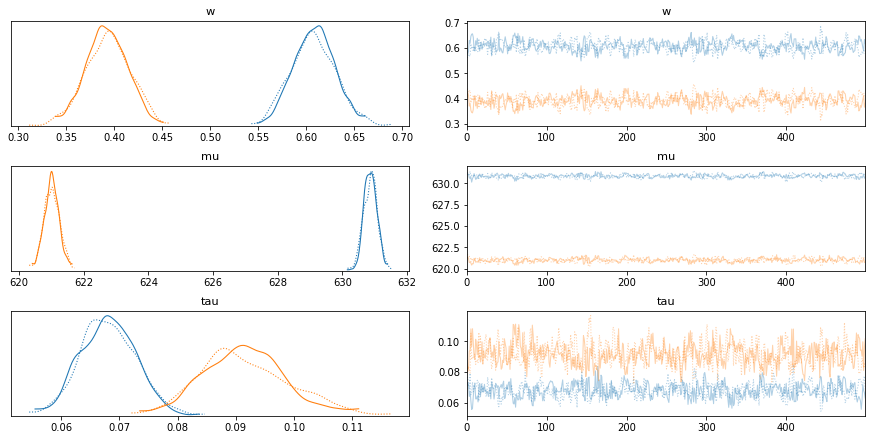

In [17]:
pm.traceplot(trace, var_names=['w', 'mu', 'tau']);

In [18]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

/usr/local/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [01:44<00:00,  4.80it/s]


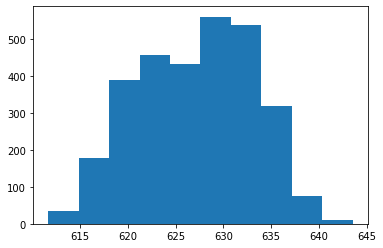

In [19]:
plt.hist(ppc['x_obs'][0]);

In [20]:
with model:
    # DV
    inference = pm.ADVI()
    approx = pm.fit(
        method=inference, n=50000,
        obj_optimizer=pm.adam()
    )

Average Loss = 9,673.3: 100%|██████████| 50000/50000 [01:17<00:00, 644.05it/s]  
Finished [100%]: Average Loss = 9,673.3


In [21]:
samples = approx.sample(300)

([array([ 3., 10., 24., 42., 68., 76., 43., 26.,  7.,  1.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 300.,   0.])],
 array([573.01652486, 579.04937423, 585.08222361, 591.11507298,
        597.14792236, 603.18077173, 609.21362111, 615.24647048,
        621.27931986, 627.31216923, 633.34501861]),
 <a list of 2 Lists of Patches objects>)

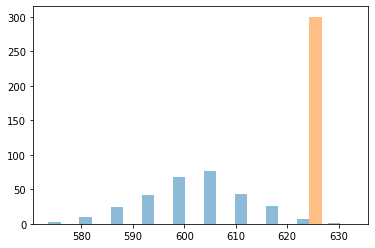

In [22]:
plt.hist(samples.get_values('mu'), alpha=0.5)

([array([295.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
  array([300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])],
 array([2.30797709e-03, 7.79771305e+00, 1.55931181e+01, 2.33885232e+01,
        3.11839283e+01, 3.89793334e+01, 4.67747384e+01, 5.45701435e+01,
        6.23655486e+01, 7.01609537e+01, 7.79563587e+01]),
 <a list of 2 Lists of Patches objects>)

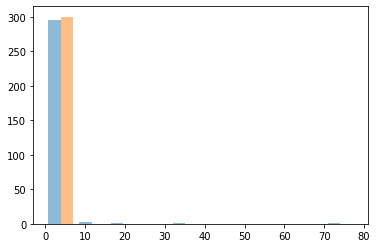

In [23]:
plt.hist(samples.get_values('tau'), alpha=0.5)

([array([300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 300.])],
 array([5.15366505e-06, 1.00004123e-01, 2.00003092e-01, 3.00002061e-01,
        4.00001031e-01, 5.00000000e-01, 5.99998969e-01, 6.99997939e-01,
        7.99996908e-01, 8.99995877e-01, 9.99994846e-01]),
 <a list of 2 Lists of Patches objects>)

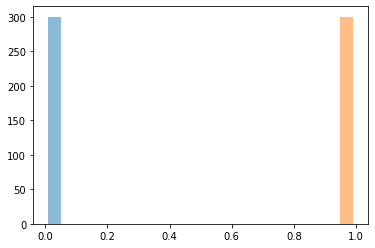

In [24]:
plt.hist(samples.get_values('w'), alpha=0.5)

In [25]:
ppc = pm.sample_posterior_predictive(samples, samples=500, model=model)

100%|██████████| 500/500 [01:44<00:00,  4.77it/s]


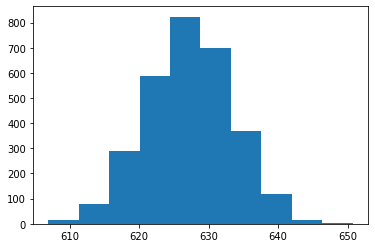

In [26]:
plt.hist(ppc['x_obs'][0]);

## 公式ドキュメント

https://docs.pymc.io/notebooks/marginalized_gaussian_mixture_model.html

In [27]:
SEED = 383561

np.random.seed(SEED) # from random.org, for reproducibility

In [28]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


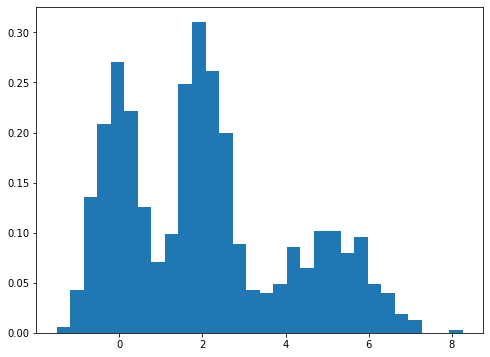

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True, lw=0);

In [30]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)
    
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:40<00:00, 294.34draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


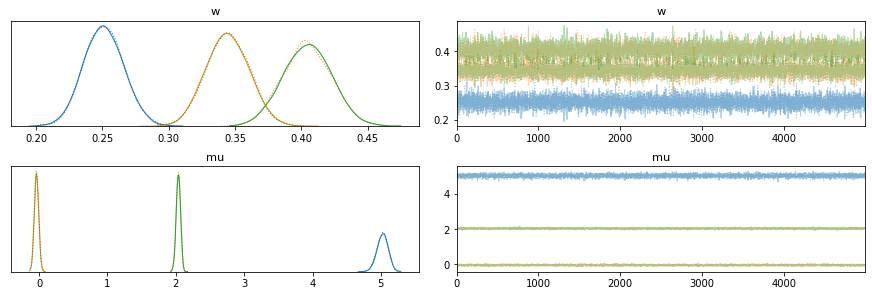

In [31]:
pm.traceplot(trace, var_names=['w', 'mu']);

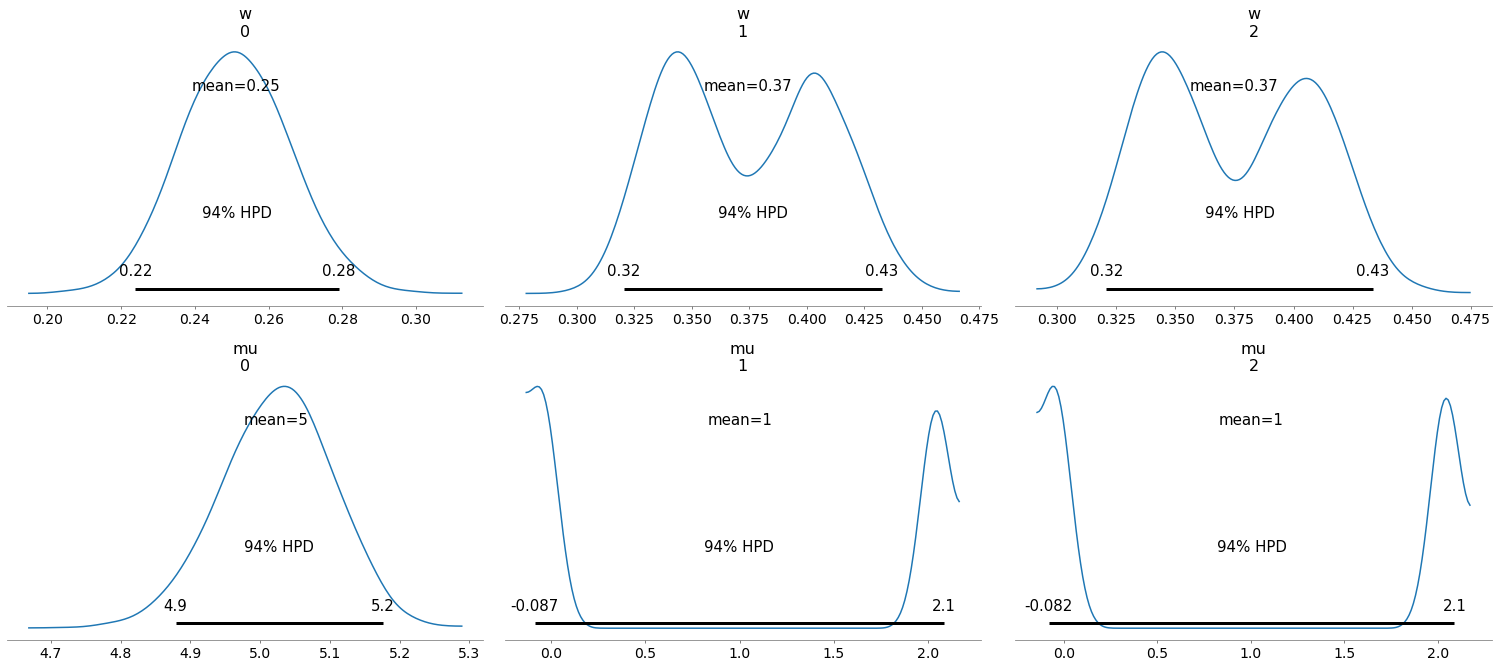

In [32]:
pm.plot_posterior(trace, var_names=['w', 'mu']);

In [33]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 5000, random_seed=SEED)

/usr/local/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 5000/5000 [08:12<00:00, 10.14it/s]


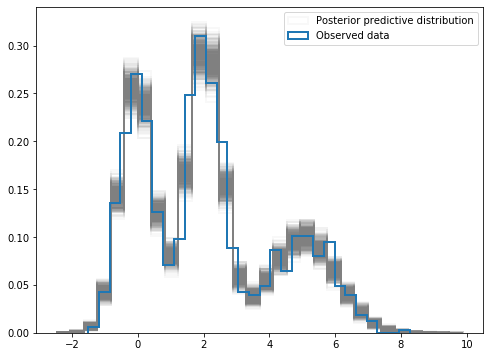

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(ppc_trace['x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['x_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

## 天下のsklearnも使ってみる

In [35]:
from sklearn.mixture import GaussianMixture
import matplotlib.mlab as mlab

In [36]:
# GaussianMixtureの学習
gmm = GaussianMixture(
    n_components=k,
    covariance_type='spherical'
).fit(
    np.array(data['z'].values).reshape(-1, 1)  # 次元数2を入力とするため変形
)

In [37]:
print(gmm.weights_)

[0.56290351 0.43709649]


In [38]:
print(gmm.means_)

[[631.29161926]
 [621.47009769]]


In [39]:
print(gmm.covariances_)

[12.89846011 12.48738662]


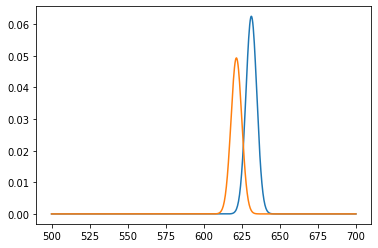

In [40]:
x = np.linspace(500, 700, 600)

for i in range(k):
    plt.plot(x, gmm.weights_[i] * stats.norm.pdf(x, gmm.means_[i, -1], np.sqrt(gmm.covariances_[i])))

## daftでグラフィカルモデルを描画

In [41]:
import daft
from matplotlib import rc

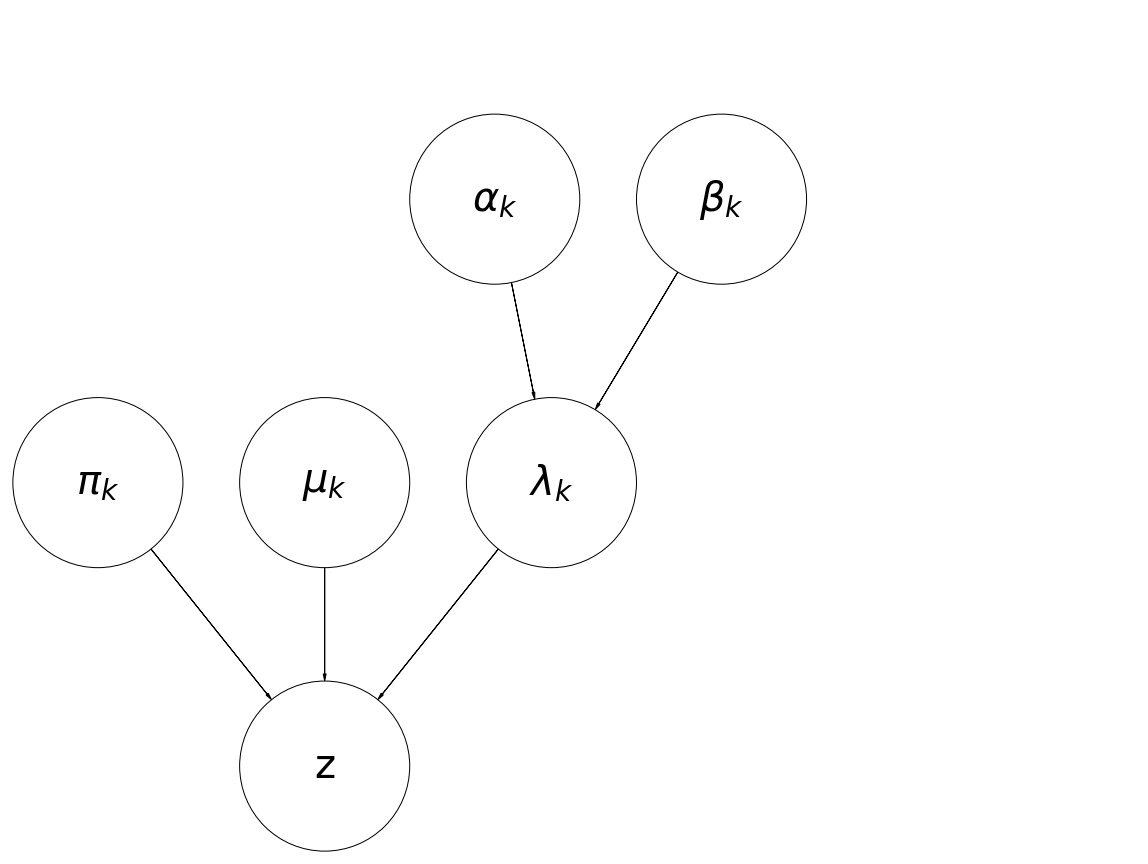

In [43]:
rc("font", family="sans-serif", size=40)

pgm = daft.PGM(shape=[20, 15], node_unit = 6)

pgm.add_node(daft.Node("alpha", r"$\alpha_k$", 9, 12)) 
pgm.add_node(daft.Node("beta", r"$\beta_k$", 13, 12)) 
pgm.add_node(daft.Node("lambda", r"$\lambda_k$", 10, 7)) 
pgm.add_node(daft.Node("mu", r"$\mu_k$", 6, 7)) 
pgm.add_node(daft.Node("pi", r"$\pi_k$", 2, 7)) 
pgm.add_node(daft.Node("z", r"z", 6, 2)) 

pgm.add_edge("alpha", "lambda")
pgm.add_edge("beta", "lambda")
pgm.add_edge("lambda", "z")
pgm.add_edge("mu", "z")
pgm.add_edge("pi", "z")

pgm.render()